# Analysis of Nea. ancestry

In [1]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../code/utils.R")

})

In [2]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [3]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [4]:
EIGENSTRAT_DIR <- "../data/eigenstrat/bigyri_ho/"

EIGENSTRAT_OLD <- paste0(EIGENSTRAT_DIR, "all")
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "all_HO")

SNP_FILE <- paste0(EIGENSTRAT, ".snp")
GENO_FILE <- paste0(EIGENSTRAT, ".geno")
IND_FILE <- paste0(EIGENSTRAT, ".ind")

subset_sites(prefix=EIGENSTRAT_OLD, out_prefix=EIGENSTRAT, bed_file="../data/bed/bigyri_array.bed", complement=TRUE)

### Calculate the number of SNPs available for each sample on the 2.2M array

In [5]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

In [6]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Archaics=c("new_Altai", "new_Denisova")))

In [7]:
iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                        prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

# Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure

In [8]:
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
mende  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mende", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [9]:
merge_pops(IND_FILE, paste0(IND_FILE, ".Africans"),
           merge=list(Africans=c("Yoruba", "Mbuti", "Mende", "Dinka")))

In [10]:
africans  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Africans", O="Chimp", prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".Africans"))

In [11]:
options(repr.plot.width=9, repr.plot.height=5)

### Merge all f4 results:

In [13]:
results <- inner_join(bind_rows(iceage_Nea, mbuti,  yoruba, mende, dinka, africans),
                      snp_counts_f4, by=c("X"="name")) %>%
    select(-c(A, B, C, O)) %>%
    inner_join(samples, by=c("X"="name")) %>%
    mutate(se=alpha / Zscore) %>%
    mutate(sites="BigYRI")

# Plot Nea. estimates over time

In [14]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

In [15]:
eur_nea <- filter(results, pop %in% c("EMH", "WestEurasia"), ! X %in% non_udg_samples)

In [16]:
plot_nea_vs_time <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=-Inf, ylim=c(0, 0.1), plot_ci=TRUE) {
    x <- if (plot_ci) 1.96 else 0
    filter(eur_nea,
           setup == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count, color=abs(Zscore) > 3), alpha=3/4) +
        geom_errorbar(aes(ymin=alpha - x * se, ymax=alpha + x * se, color=abs(Zscore) > 3)) +
        geom_smooth(aes(weight=snp_count), data=filter(., abs(Zscore) > x), method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlab("age [years before present]") + ylab("Neanderthal ancestry proportion") +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) #+
        #ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=0) {
    filter(eur_nea,
           setup == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>%
    { lm(.[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]]) }
}

## Results from the Ice Age paper

In [30]:
cutoff <- 150000

In [17]:
options(repr.plot.width=9, repr.plot.height=5)

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 23 rows containing missing values (geom_errorbar).”

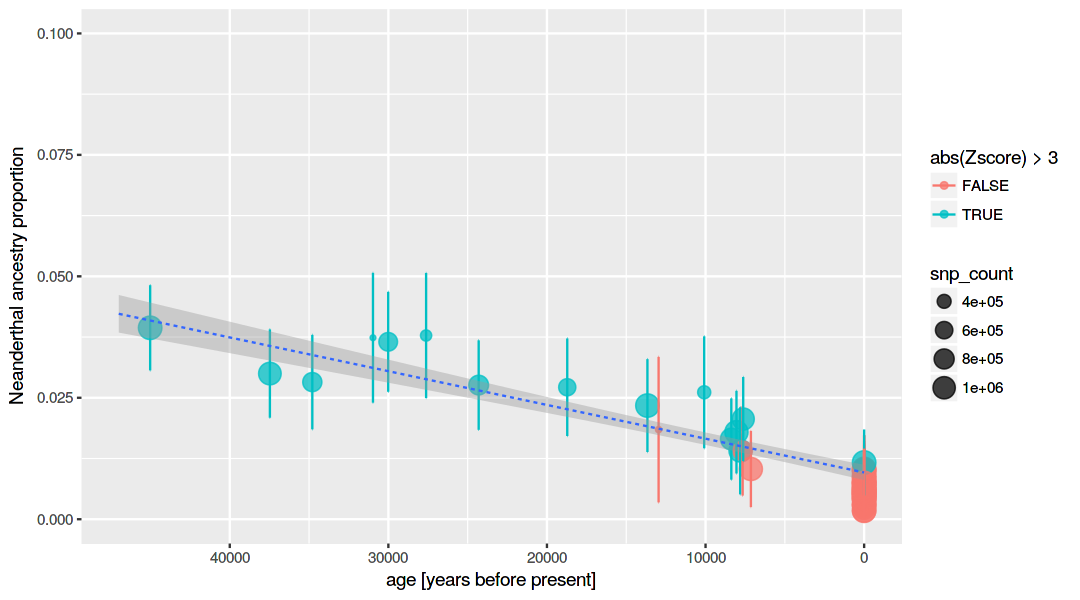

In [31]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Archaics_Dinka_Chimp", ylim=c(0, 0.1), snp_cutoff=cutoff)

# New f4 results

In [23]:
options(repr.plot.width=9, repr.plot.height=5)


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-5883663 -5129699 -4672595  2855894 42568482 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      1352      10914   0.124    0.902
.[["alpha"]]   164982     522791   0.316    0.754

Residual standard error: 10720000 on 50 degrees of freedom
Multiple R-squared:  0.001988,	Adjusted R-squared:  -0.01797 
F-statistic: 0.09959 on 1 and 50 DF,  p-value: 0.7536



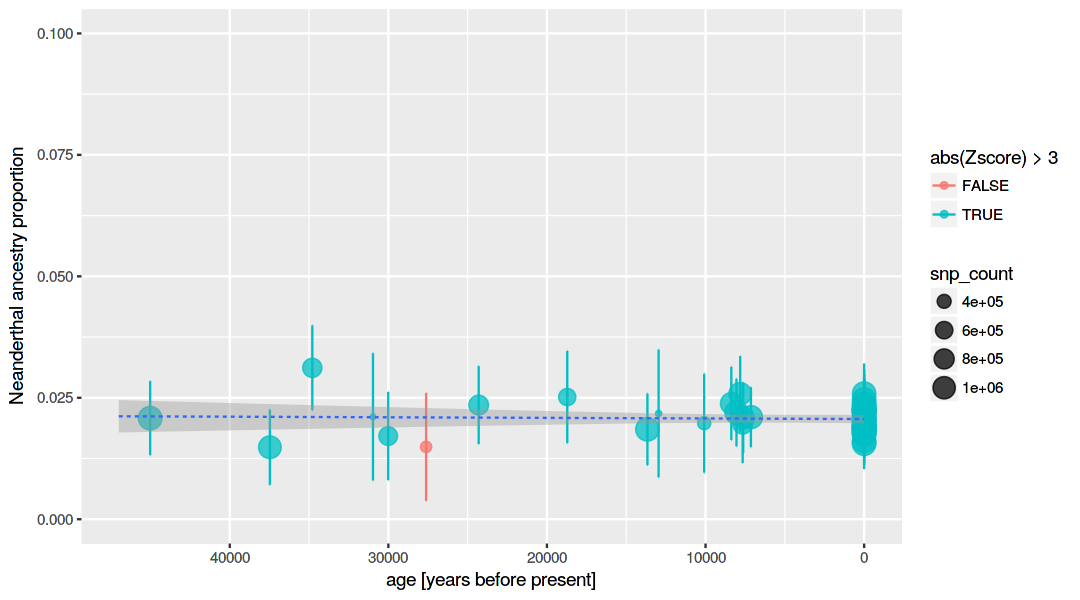

In [32]:
"qpF4ratio__new_Altai_new_Vindija_Africans_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-5703055 -5206345 -4777131  3142259 42609104 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      7104       9962   0.713    0.479
.[["alpha"]]  -123571     520314  -0.237    0.813

Residual standard error: 10720000 on 50 degrees of freedom
Multiple R-squared:  0.001127,	Adjusted R-squared:  -0.01885 
F-statistic: 0.0564 on 1 and 50 DF,  p-value: 0.8132



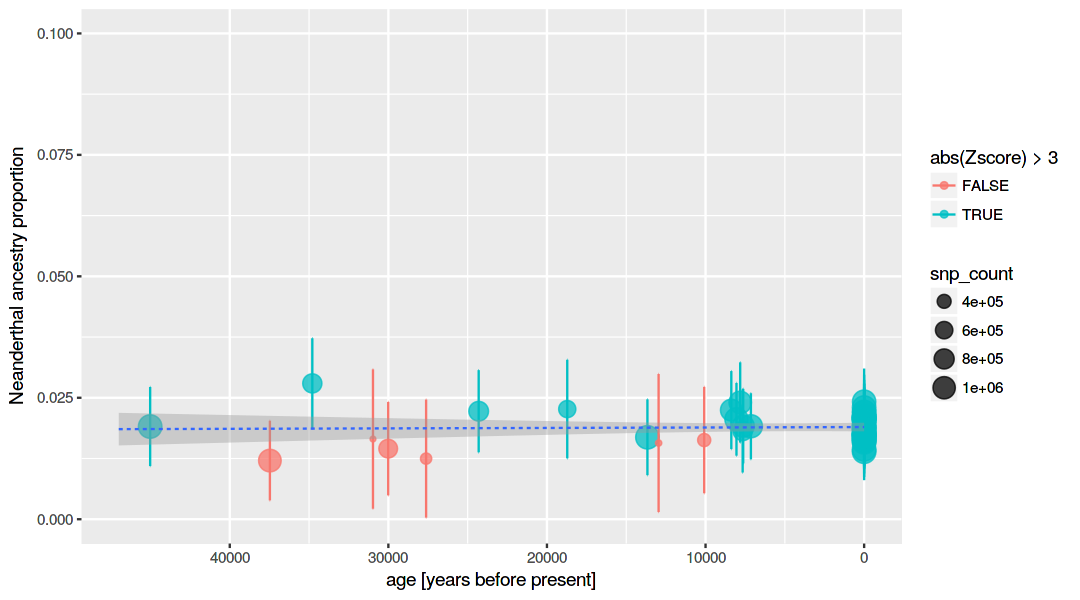

In [33]:
"qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-7016098 -5219243 -4242444  2744444 42565610 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)     -3888      11890  -0.327    0.745
.[["alpha"]]   376630     513492   0.733    0.467

Residual standard error: 10670000 on 50 degrees of freedom
Multiple R-squared:  0.01064,	Adjusted R-squared:  -0.009142 
F-statistic: 0.538 on 1 and 50 DF,  p-value: 0.4667



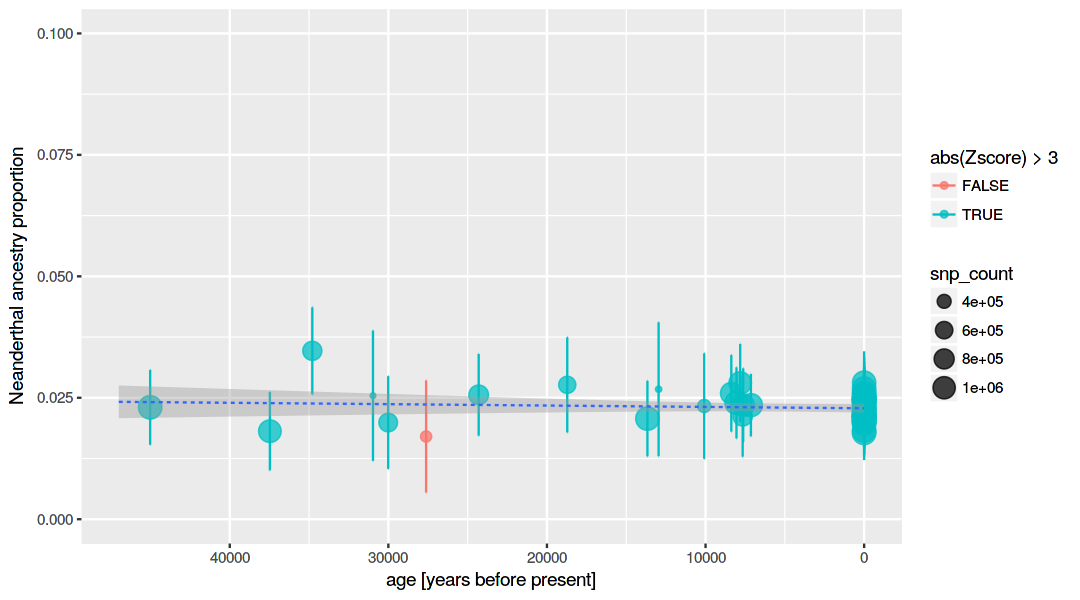

In [34]:
"qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-6431843 -5186756 -4432177  2775925 42564627 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    -699.3    10729.3  -0.065    0.948
.[["alpha"]] 267764.4   520726.3   0.514    0.609

Residual standard error: 10700000 on 50 degrees of freedom
Multiple R-squared:  0.00526,	Adjusted R-squared:  -0.01463 
F-statistic: 0.2644 on 1 and 50 DF,  p-value: 0.6094



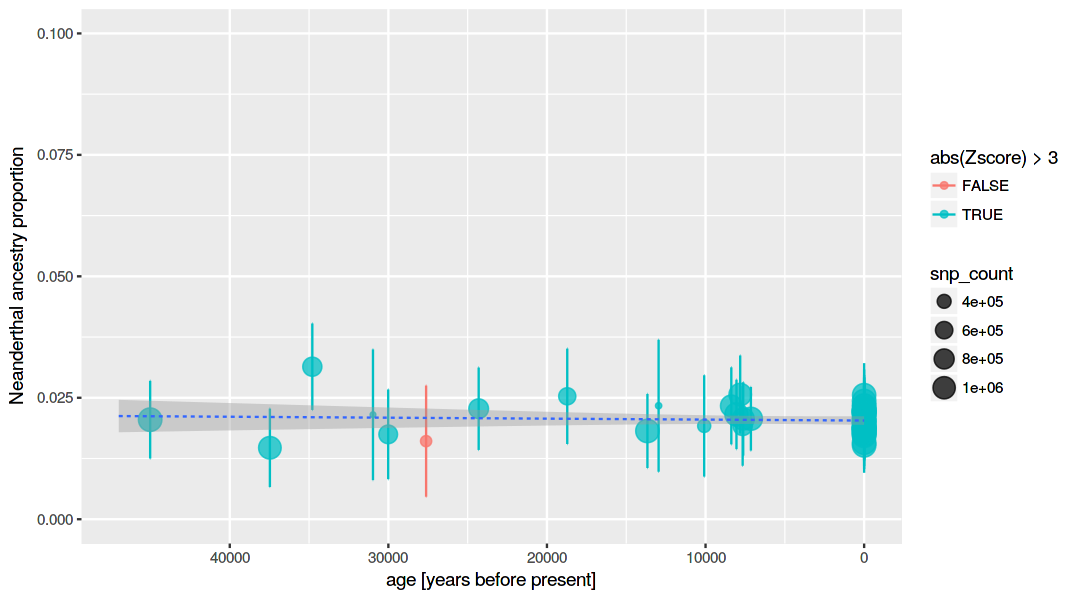

In [35]:
"qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]])

Weighted Residuals:
     Min       1Q   Median       3Q      Max 
-6359741 -5176135 -4459250  2828860 42532508 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    -650.6    11058.4  -0.059    0.953
.[["alpha"]] 255013.1   516027.4   0.494    0.623

Residual standard error: 10700000 on 50 degrees of freedom
Multiple R-squared:  0.004861,	Adjusted R-squared:  -0.01504 
F-statistic: 0.2442 on 1 and 50 DF,  p-value: 0.6233



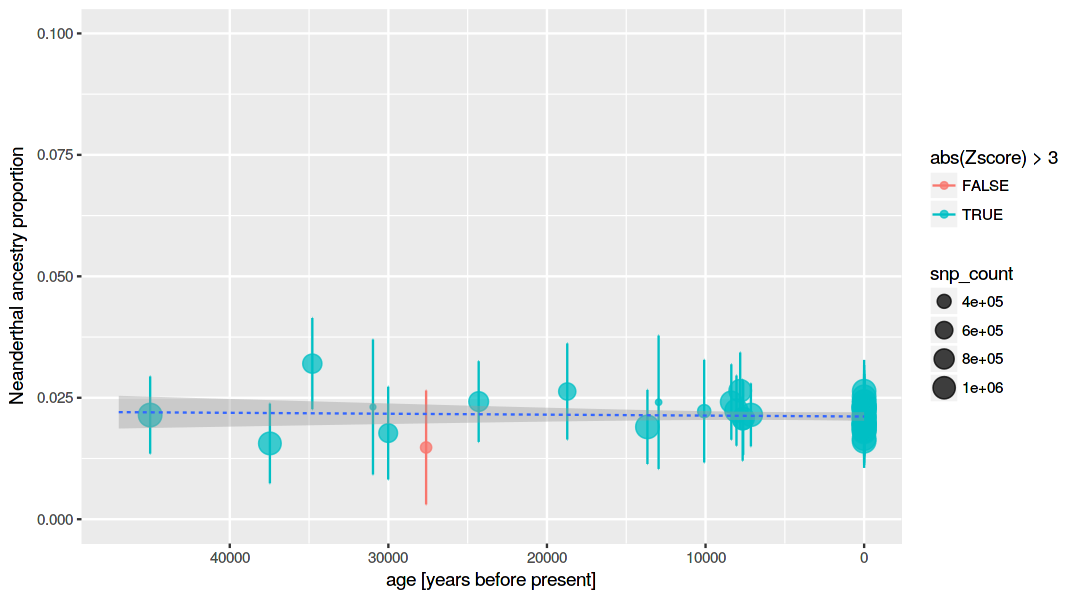

In [37]:
"qpF4ratio__new_Altai_new_Vindija_Mende_Chimp" %>% {
    run_lm(., snp_cutoff = cutoff) %>% summary %>% print
    plot_nea_vs_time(., snp_cutoff = cutoff)
}

## Europeans vs East Asians

In [38]:
options(repr.plot.width=9, repr.plot.height=4)

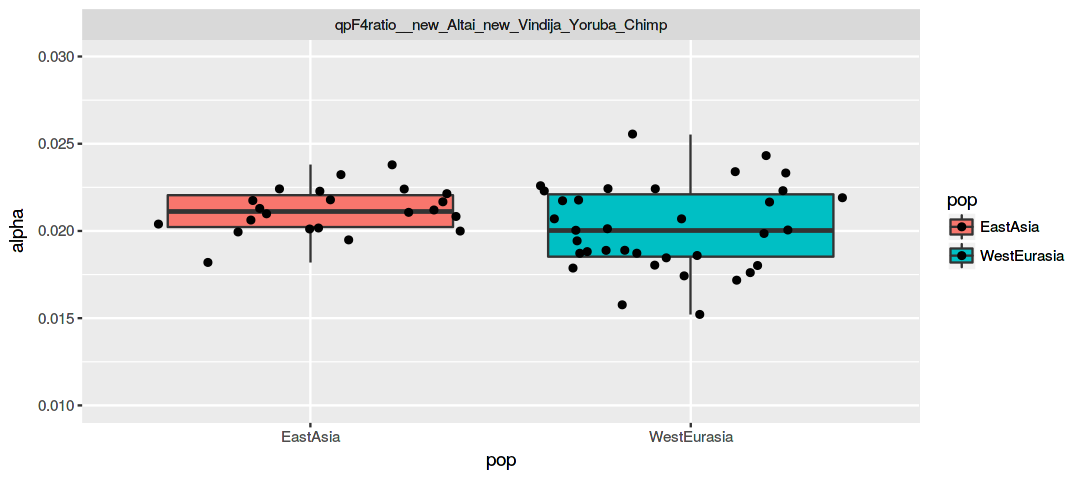

In [39]:
filter(results,
       pop %in% c("WestEurasia", "EastAsia"),
       setup %in% c("direct", "qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")) %>%
ggplot(aes(pop, alpha, fill=pop)) + geom_boxplot() + geom_jitter() + facet_grid(~ setup) +
ylim(0.01, 0.03)

In [40]:
saveRDS(filter(eur_nea, setup != "direct"), "../data/RData/admixtools_nea_ancestry-HO.rds")